In [ ]:
!pip install numpy
!pip install pandas
!pip install catboost
!pip install imblearn

Загрузим данные и библиотеки

In [34]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier,CatBoostRegressor
from imblearn.over_sampling import SMOTE, RandomOverSampler

df = pd.read_parquet('END_minmax_rev.parquet')
df_test = pd.read_parquet('SUB.parquet')

add = pd.read_parquet('revenue.parquet')
add_test = pd.read_parquet('revenue_1.parquet')

submit = pd.DataFrame({'customer_id':df_test.customer_id,'buy_post':None,'date_diff_post':None})

Удалим лишние столбцы и получим размерность данных

In [35]:
df.drop(['revenue','toilet','weekday_h','Free-standing'],axis=1,inplace=True)

add.drop('buy_post',axis=1,inplace=True)

df.shape, df_test.shape

((496888, 35), (112334, 37))

Добавим новые данные в датасет, обработаем его и разделим их

In [36]:
df = pd.merge(df, add, on='customer_id', how='inner')

df['s/p']=df['revenue']/df['purchase_count']

df.average_time_between_purchases.fillna(0,inplace=True)
df.std_customer.fillna(0, inplace=True)

df.drop(['dish_name', 'format_name', 'revenue_delta_class', 'most_common_pattern', 'customer_id'], axis = 1, inplace = True)

X, y = df.drop(['date_diff_post', 'buy_post'], axis=1), df['buy_post']

Обучим CatBoost модель

In [37]:
filterwarnings('ignore')

oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
Xtrain, ytrain = oversampler.fit_resample(X, y)

model = CatBoostClassifier(random_state = 42)
model.fit(Xtrain,ytrain)

Learning rate set to 0.023487
0:	learn: 0.6890365	total: 21.8ms	remaining: 21.8s
1:	learn: 0.6851502	total: 43ms	remaining: 21.5s
2:	learn: 0.6814662	total: 63.2ms	remaining: 21s
3:	learn: 0.6779299	total: 87.8ms	remaining: 21.9s
4:	learn: 0.6745988	total: 111ms	remaining: 22s
5:	learn: 0.6714200	total: 134ms	remaining: 22.2s
6:	learn: 0.6685227	total: 156ms	remaining: 22.1s
7:	learn: 0.6656807	total: 177ms	remaining: 21.9s
8:	learn: 0.6630815	total: 199ms	remaining: 21.9s
9:	learn: 0.6605564	total: 221ms	remaining: 21.9s
10:	learn: 0.6580696	total: 243ms	remaining: 21.9s
11:	learn: 0.6556864	total: 265ms	remaining: 21.8s
12:	learn: 0.6535308	total: 287ms	remaining: 21.8s
13:	learn: 0.6513381	total: 308ms	remaining: 21.7s
14:	learn: 0.6493444	total: 329ms	remaining: 21.6s
15:	learn: 0.6473757	total: 351ms	remaining: 21.6s
16:	learn: 0.6455040	total: 369ms	remaining: 21.3s
17:	learn: 0.6437254	total: 389ms	remaining: 21.2s
18:	learn: 0.6420251	total: 409ms	remaining: 21.1s
19:	learn: 0.

Вывод наиболее релевантных фич

In [38]:
pd.DataFrame({'cols':X.columns ,'imp':model.feature_importances_}).sort_values('imp', ascending=False)

,cols,imp
12,total_time_between_purchases,25.833721
28,revenue,16.095876
13,average_time_between_purchases,13.030270
4,month_h,10.763537
29,s/p,5.110547
18,7_burger,2.486719
0,ownareaall_sqm,2.345857
5,quarter_h,1.956825
24,5_fri,1.761534
21,6_snacks,1.695399


Обаботка тестового датасета, сохранение предсказаний теста


In [39]:
df_test.drop(['revenue','toilet','weekday_h','Free-standing'],axis=1,inplace=True)
df_test['revenue']=add_test['revenue']
df_test['s/p']=df['revenue']/df['purchase_count']
df_test.drop(['dish_name', 'format_name', 'revenue_delta_class', 'most_common_pattern', 'customer_id'], axis = 1, inplace = True)

pred = model.predict(df_test)

submit.buy_post = pred


Прогнозирование через сколько придет клиент

In [53]:
df['date_diff_post'] =  df['date_diff_post'].fillna(0)
X['buy_post'], y_reg = y , df['date_diff_post']
model = CatBoostRegressor(verbose=100, iterations=600, task_type='GPU', eval_metric='RMSE')
model.fit(X, y_reg)

Learning rate set to 0.123585
0:	learn: 16.1168018	total: 16.3ms	remaining: 9.77s
100:	learn: 11.6968106	total: 1.34s	remaining: 6.64s
200:	learn: 11.6663581	total: 2.63s	remaining: 5.23s
300:	learn: 11.6397866	total: 3.86s	remaining: 3.84s
400:	learn: 11.6164479	total: 5.04s	remaining: 2.5s
500:	learn: 11.5941010	total: 6.26s	remaining: 1.24s
599:	learn: 11.5740881	total: 7.42s	remaining: 0us


Вывод наиболее релевантных фич

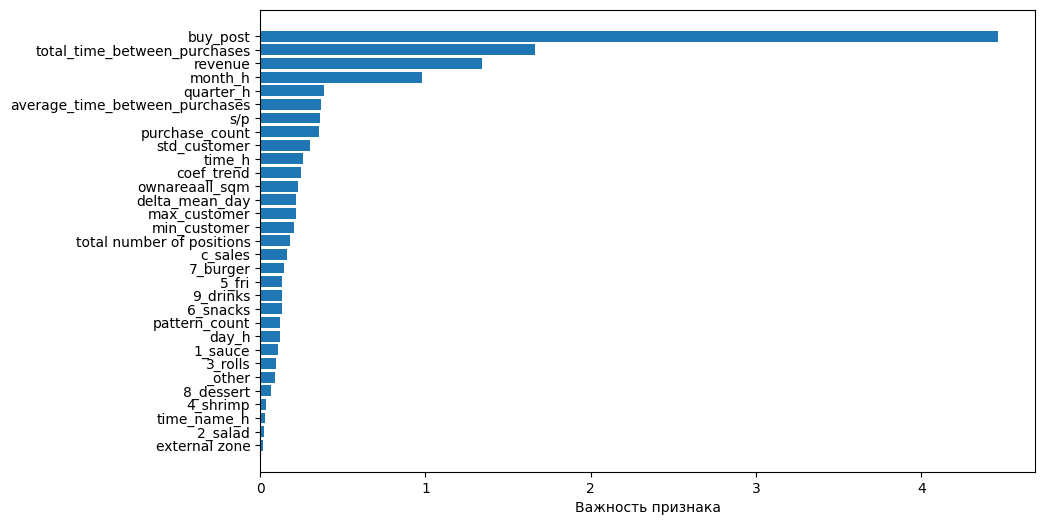

In [54]:
feature_importances = np.log(model.feature_importances_+1)
feature_names = X.columns  # предполагая, что X - это DataFrame
indices = feature_importances.argsort()

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), feature_importances[indices], align="center")
plt.yticks(range(len(indices)), feature_names[indices])
plt.xlabel("Важность признака")
plt.show()

Предикт и создание сабмита

In [55]:
df_test['buy_post'] = pred
reg_pred = model.predict(df_test)
submit.date_diff_post = pred
for index, row in submit.iterrows():
    if row['buy_post'] == 0:
        submit.at[index, 'date_diff_post'] = 0
submit.to_csv('sub_pred.csv',sep=';',index=False) 